<a href="https://colab.research.google.com/github/howard-haowen/NLP-demos/blob/main/NSYSU/W02-topic-modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is adapted from [this one](https://github.com/explosion/spacy-notebooks/blob/master/notebooks/conference_notebooks/pydays/topic_modelling.ipynb) included in the [explosion
/spacy-notebooks repo](https://github.com/explosion/spacy-notebooks).

In [1]:
from datetime import date

today = date.today()
print("Last updated:", today)

Last updated: 2022-04-22


# Topic Modelling with Gensim

This tutorial will walk you through the entire process of analysing your text - from pre-processing to creating your topic models and visualising them. 

We will be needing: 
```
- spaCy
- gensim
- matplotlib
- pyLDAVis
```


![](https://miro.medium.com/max/1400/1*jpytbqadO3FtdIyOjx2_yg.png)

## Dependencies

In [2]:
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm
!pip install pyldavis

     |████████████████████████████████| 2.1 MB 8.3 MB/s 
     |████████████████████████████████| 1.1 MB 38.3 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.3/653.3 KB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.1/457.1 KB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 KB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 42.1 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.1.1
    Uninstalling typing_extensions-4.1.1:
      Successfully uninstalled typing_extensions-4.1.1
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempt

In [3]:
# NLP
import spacy
# corpus
import nltk
# topic modelling
import gensim
from gensim.models import LdaModel, HdpModel
from gensim.corpora import Dictionary
# visualization
import pyLDAvis.gensim_models
# tabularization of data
import pandas as pd
# others
import warnings
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [4]:
spacy.info()

{'location': '/usr/local/lib/python3.7/dist-packages/spacy',
 'pipelines': {'en_core_web_sm': '3.2.0'},
 'platform': 'Linux-5.4.144+-x86_64-with-Ubuntu-18.04-bionic',
 'python_version': '3.7.13',
 'spacy_version': '3.2.4'}

In [5]:
pd.options.plotting.backend = "plotly"

## Download the corpus

For this tutorial, we will be using the **Inaugural Address Corpus** from NLTK. Visit [here](http://www.nltk.org/nltk_data/) for a complete list of corpora accessible through NLTK.

We should keep in mind we can use pretty much any textual dataset and go ahead with what we will be doing. 

In [6]:
nltk.download('punkt')
nltk.download('inaugural')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package inaugural to /root/nltk_data...
[nltk_data]   Unzipping corpora/inaugural.zip.


True

In [7]:
from nltk.corpus import inaugural

In [8]:
file_ids = inaugural.fileids()
file_ids

['1789-Washington.txt',
 '1793-Washington.txt',
 '1797-Adams.txt',
 '1801-Jefferson.txt',
 '1805-Jefferson.txt',
 '1809-Madison.txt',
 '1813-Madison.txt',
 '1817-Monroe.txt',
 '1821-Monroe.txt',
 '1825-Adams.txt',
 '1829-Jackson.txt',
 '1833-Jackson.txt',
 '1837-VanBuren.txt',
 '1841-Harrison.txt',
 '1845-Polk.txt',
 '1849-Taylor.txt',
 '1853-Pierce.txt',
 '1857-Buchanan.txt',
 '1861-Lincoln.txt',
 '1865-Lincoln.txt',
 '1869-Grant.txt',
 '1873-Grant.txt',
 '1877-Hayes.txt',
 '1881-Garfield.txt',
 '1885-Cleveland.txt',
 '1889-Harrison.txt',
 '1893-Cleveland.txt',
 '1897-McKinley.txt',
 '1901-McKinley.txt',
 '1905-Roosevelt.txt',
 '1909-Taft.txt',
 '1913-Wilson.txt',
 '1917-Wilson.txt',
 '1921-Harding.txt',
 '1925-Coolidge.txt',
 '1929-Hoover.txt',
 '1933-Roosevelt.txt',
 '1937-Roosevelt.txt',
 '1941-Roosevelt.txt',
 '1945-Roosevelt.txt',
 '1949-Truman.txt',
 '1953-Eisenhower.txt',
 '1957-Eisenhower.txt',
 '1961-Kennedy.txt',
 '1965-Johnson.txt',
 '1969-Nixon.txt',
 '1973-Nixon.txt',
 '1

In [9]:
len(file_ids)

59

In [10]:
#show the last speech, which is Biden's
inaugural.raw(file_ids[-1])

'Chief Justice Roberts, Vice President Harris, Speaker Pelosi, Leader Schumer, Leader McConnell, Vice President Pence, and my distinguished guests, and my fellow Americans: This is America\'s day. This is democracy\'s day, a day of history and hope, of renewal and resolve. Through a crucible for the ages America has been tested anew, and America has risen to the challenge.\n\nToday we celebrate the triumph not of a candidate, but of a cause, the cause of democracy. The peopleâ\x80\x94the will of the people has been heard, and the will of the people has been heeded. We\'ve learned again that democracy is precious, democracy is fragile. And at this hour, my friends, democracy has prevailed.\n\nSo now, on this hallowed ground where just a few days ago violence sought to shake the Capitol\'s very foundation, we come together as one Nation under God, indivisible, to carry out the peaceful transfer of power as we have for more than two centuries. As we look ahead in our uniquely American way

### Tabularize the dataset

In [11]:
years = [id[:4] for id in file_ids]
presidents = [id[5:].replace(".txt", "") for id in file_ids]
texts = [inaugural.raw(id) for id in file_ids]
df = pd.DataFrame(
    {
        "year": years,
        "president": presidents,
        "text": texts,
    }
)

In [12]:
df.set_index("year", inplace=True)
df.index = df.index.astype(int)
df

,president,text
year,,
1789,Washington,Fellow-Citizens of the Senate and of the House...
1793,Washington,"Fellow citizens, I am again called upon by the..."
1797,Adams,"When it was first perceived, in early times, t..."
1801,Jefferson,Friends and Fellow Citizens:\n\nCalled upon to...
1805,Jefferson,"Proceeding, fellow citizens, to that qualifica..."
1809,Madison,Unwilling to depart from examples of the most ...
1813,Madison,About to add the solemnity of an oath to the o...
1817,Monroe,I should be destitute of feeling if I was not ...
1821,Monroe,"Fellow citizens, I shall not attempt to descri..."


In [13]:
df.text.apply(len).plot()

## Preprocess data

It's been often said in Machine Learning and NLP algorithms - garbage in, garbage out. We can't have state-of-the-art results without data which is aa good. Let's spend this section working on cleaning and understanding our data set.

NTLK is usually a popular choice for pre-processing - but is a rather [outdated](https://explosion.ai/blog/dead-code-should-be-buried) and we will be checking out spaCy, an industry grade text-processing package. 

There is no correct way of doing text preprocessing, but it often involves two steps:
- filtering: to remove unwanted tokens
- standardization: to reduce the number of unique tokens

In [14]:
year = 2021
biden = df.loc[year, 'text']
biden

'Chief Justice Roberts, Vice President Harris, Speaker Pelosi, Leader Schumer, Leader McConnell, Vice President Pence, and my distinguished guests, and my fellow Americans: This is America\'s day. This is democracy\'s day, a day of history and hope, of renewal and resolve. Through a crucible for the ages America has been tested anew, and America has risen to the challenge.\n\nToday we celebrate the triumph not of a candidate, but of a cause, the cause of democracy. The peopleâ\x80\x94the will of the people has been heard, and the will of the people has been heeded. We\'ve learned again that democracy is precious, democracy is fragile. And at this hour, my friends, democracy has prevailed.\n\nSo now, on this hallowed ground where just a few days ago violence sought to shake the Capitol\'s very foundation, we come together as one Nation under God, indivisible, to carry out the peaceful transfer of power as we have for more than two centuries. As we look ahead in our uniquely American way

In [15]:
clean_biden = [char if char.isascii() else " " for char in biden]
clean_biden = "".join(clean_biden)
clean_biden

'Chief Justice Roberts, Vice President Harris, Speaker Pelosi, Leader Schumer, Leader McConnell, Vice President Pence, and my distinguished guests, and my fellow Americans: This is America\'s day. This is democracy\'s day, a day of history and hope, of renewal and resolve. Through a crucible for the ages America has been tested anew, and America has risen to the challenge.\n\nToday we celebrate the triumph not of a candidate, but of a cause, the cause of democracy. The people   the will of the people has been heard, and the will of the people has been heeded. We\'ve learned again that democracy is precious, democracy is fragile. And at this hour, my friends, democracy has prevailed.\n\nSo now, on this hallowed ground where just a few days ago violence sought to shake the Capitol\'s very foundation, we come together as one Nation under God, indivisible, to carry out the peaceful transfer of power as we have for more than two centuries. As we look ahead in our uniquely American way   res

In [16]:
nlp = spacy.load("en_core_web_sm")

In [17]:
doc = nlp(clean_biden)

In [18]:
for tok in doc[:40]:
    print(tok.text, end="|")

Chief|Justice|Roberts|,|Vice|President|Harris|,|Speaker|Pelosi|,|Leader|Schumer|,|Leader|McConnell|,|Vice|President|Pence|,|and|my|distinguished|guests|,|and|my|fellow|Americans|:|This|is|America|'s|day|.|This|is|democracy|

In [19]:
for tok in doc[:40]:
    print(tok.lemma_, end="|")

Chief|Justice|Roberts|,|Vice|President|Harris|,|Speaker|Pelosi|,|Leader|Schumer|,|Leader|McConnell|,|Vice|President|Pence|,|and|my|distinguished|guest|,|and|my|fellow|Americans|:|this|be|America|'s|day|.|this|be|democracy|

In [20]:
for tok in doc[:40]:
    print(tok.lemma_.lower(), end="|")

chief|justice|roberts|,|vice|president|harris|,|speaker|pelosi|,|leader|schumer|,|leader|mcconnell|,|vice|president|pence|,|and|my|distinguished|guest|,|and|my|fellow|americans|:|this|be|america|'s|day|.|this|be|democracy|

In [21]:
toks = [tok.text for tok in doc]
len(toks)

3109

In [22]:
for tok in doc[:40]:
    if (not tok.is_stop) and (not tok.is_punct) and (not tok.like_num) and (not tok.is_space):
        print(tok.lemma_.lower(), end="|")

chief|justice|roberts|vice|president|harris|speaker|pelosi|leader|schumer|leader|mcconnell|vice|president|pence|distinguished|guest|fellow|americans|america|day|democracy|

In [23]:
toks = [tok.lemma_.lower() for tok in doc if (not tok.is_stop) and (not tok.is_punct) and (not tok.like_num) and (not tok.is_space)]
len(toks)

1020

In [24]:
def preprocess_text(text):
    clean_text = [char if char.isascii() else " " for char in text]
    clean_text = "".join(clean_text)
    doc = nlp(clean_text)
    tokens = [tok.lemma_.lower() for tok in doc if (not tok.is_stop) and (not tok.is_punct) and (not tok.like_num) and (not tok.is_space)]
    return tokens

In [27]:
biden_tokens = preprocess_text(biden)
biden_tokens[:40]

['chief',
 'justice',
 'roberts',
 'vice',
 'president',
 'harris',
 'speaker',
 'pelosi',
 'leader',
 'schumer',
 'leader',
 'mcconnell',
 'vice',
 'president',
 'pence',
 'distinguished',
 'guest',
 'fellow',
 'americans',
 'america',
 'day',
 'democracy',
 'day',
 'day',
 'history',
 'hope',
 'renewal',
 'resolve',
 'crucible',
 'age',
 'america',
 'test',
 'anew',
 'america',
 'rise',
 'challenge',
 'today',
 'celebrate',
 'triumph',
 'candidate']

In [29]:
%time df['text'].apply(preprocess_text)

CPU times: user 26.8 s, sys: 289 ms, total: 27.1 s
Wall time: 29.9 s


year
1789    [fellow, citizens, senate, house, representati...
1793    [fellow, citizen, call, voice, country, execut...
1797    [perceive, early, time, middle, course, americ...
1801    [friends, fellow, citizens, call, undertake, d...
1805    [proceeding, fellow, citizen, qualification, c...
1809    [unwilling, depart, example, revere, authority...
1813    [add, solemnity, oath, obligation, impose, sta...
1817    [destitute, feeling, deeply, affect, strong, p...
1821    [fellow, citizen, shall, attempt, describe, gr...
1825    [compliance, usage, coeval, existence, federal...
1829    [fellow, citizen, undertake, arduous, duty, ap...
1833    [fellow, citizen, american, people, express, u...
1837    [fellow, citizen, practice, predecessor, impos...
1841    [call, retirement, suppose, continue, residue,...
1845    [fellow, citizen, solicitation, choose, free, ...
1849    [elect, american, people, high, office, know, ...
1853    [countryman, relief, feel, heart, know, person...
1857    [

In [25]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [31]:
def preprocess_texts(texts):
    clean_texts = []
    for text in texts:
        clean_text = [char if char.isascii() else " " for char in text]
        clean_text = "".join(clean_text)
        clean_texts.append(clean_text)
    
    # nlp.pipe() is more efficient than nlp()
    clean_tokens = []
    for doc in nlp.pipe(clean_texts, disable=["ner", "tagger", "parser"]):
        tokens = [tok.lemma_.lower() for tok in doc if (not tok.is_stop) and (not tok.is_punct) and (not tok.like_num) and (not tok.is_space)]
        clean_tokens.append(tokens)

    return clean_tokens

In [32]:
%time doc_tokens = preprocess_texts(df['text'])

CPU times: user 8.38 s, sys: 2.7 s, total: 11.1 s
Wall time: 11 s


In [33]:
df['tokens'] = doc_tokens
df

,president,text,tokens
year,,,
1789,Washington,Fellow-Citizens of the Senate and of the House...,"[fellow, citizens, senate, house, representati..."
1793,Washington,"Fellow citizens, I am again called upon by the...","[fellow, citizens, called, voice, country, exe..."
1797,Adams,"When it was first perceived, in early times, t...","[perceived, early, times, middle, course, amer..."
1801,Jefferson,Friends and Fellow Citizens:\n\nCalled upon to...,"[friends, fellow, citizens, called, undertake,..."
1805,Jefferson,"Proceeding, fellow citizens, to that qualifica...","[proceeding, fellow, citizens, qualification, ..."
1809,Madison,Unwilling to depart from examples of the most ...,"[unwilling, depart, examples, revered, authori..."
1813,Madison,About to add the solemnity of an oath to the o...,"[add, solemnity, oath, obligations, imposed, s..."
1817,Monroe,I should be destitute of feeling if I was not ...,"[destitute, feeling, deeply, affected, strong,..."
1821,Monroe,"Fellow citizens, I shall not attempt to descri...","[fellow, citizens, shall, attempt, describe, g..."


And this is the magic of spaCy - just like that, we've managed to get rid of stopwords, punctauation markers, and added the lemmatized word. There's lot more we can do with spaCy which I would really recommend checking out.

### N-gram model

![](https://www.oreilly.com/library/view/fasttext-quick-start/9781789130997/assets/4b93186c-0e7e-4b99-81e3-86d6d9646dd5.jpg)

Sometimes topic models make more sense when 'New' and 'York' are treated as 'New_York' - we can do this by creating a bigram model and modifying our corpus accordingly.

In [34]:
texts = df['tokens'].tolist()

In [35]:
bigram = gensim.models.Phrases(texts)

In [36]:
texts = [bigram[text] for text in texts]

In [37]:
texts[0][-30:]

['supplication',
 'pleased',
 'favor',
 'american_people',
 'opportunities',
 'deliberating',
 'perfect',
 'tranquillity',
 'dispositions',
 'deciding',
 'unparalleled',
 'unanimity',
 'form_government',
 'security',
 'union',
 'advancement',
 'happiness',
 'divine',
 'blessing',
 'equally',
 'conspicuous',
 'enlarged',
 'views',
 'temperate',
 'consultations',
 'wise',
 'measures',
 'success',
 'government',
 'depend']

A gensim dictionary stores a mapping between tokens and their integer IDs.

In [38]:
dictionary = Dictionary(texts)

In [39]:
dictionary[0]

'accomplished'

In [40]:
dictionary.token2id

{'accomplished': 0,
 'accordingly': 1,
 'acknowledge': 2,
 'acquit': 3,
 'act': 4,
 'actual': 5,
 'actuate': 6,
 'add': 7,
 'addition': 8,
 'addressed': 9,
 'administration': 10,
 'adopt': 11,
 'adore': 12,
 'adorn': 13,
 'advanced': 14,
 'advancement': 15,
 'advantage': 16,
 'advantageously': 17,
 'affairs': 18,
 'affected': 19,
 'affectionate': 20,
 'affections': 21,
 'agency': 22,
 'aids': 23,
 'allotted': 24,
 'almighty': 25,
 'alteration': 26,
 'american_people': 27,
 'animosities': 28,
 'anticipation': 29,
 'anxieties': 30,
 'appreciation': 31,
 'ardent': 32,
 'arduous': 33,
 'arising': 34,
 'article': 35,
 'assemblage': 36,
 'assembled': 37,
 'assure': 38,
 'asylum': 39,
 'attachments': 40,
 'attention': 41,
 'attributes': 42,
 'auspiciously': 43,
 'author': 44,
 'aver': 45,
 'avoid': 46,
 'await': 47,
 'awaken': 48,
 'awakened': 49,
 'behold': 50,
 'benediction': 51,
 'benefits': 52,
 'benign': 53,
 'birth': 54,
 'blessing': 55,
 'blessings': 56,
 'bound': 57,
 'brief': 58,
 'b

In [41]:
print(dictionary)

Dictionary(8981 unique tokens: ['accomplished', 'accordingly', 'acknowledge', 'acquit', 'act']...)


### Bag of words (BOW)

![](https://miro.medium.com/max/1322/1*3K9GIOVLNu0cRvQap_KaRg.png)

A gensim corpus stores a mapping between word IDs and their frequencies in a document.

In [42]:
corpus = [dictionary.doc2bow(text) for text in texts]

`docid` can be any number between 0 and 58 because there are 59 documents in the corpus.

In [43]:
# docid 58 refers to Biden's speech
docid = 58
corpus[docid]

[(4, 2),
 (7, 2),
 (60, 2),
 (72, 1),
 (95, 2),
 (102, 4),
 (104, 2),
 (106, 6),
 (134, 1),
 (138, 2),
 (149, 1),
 (159, 1),
 (177, 2),
 (184, 1),
 (185, 1),
 (192, 1),
 (197, 3),
 (200, 4),
 (206, 6),
 (210, 2),
 (216, 3),
 (222, 3),
 (224, 1),
 (229, 1),
 (248, 1),
 (254, 3),
 (256, 1),
 (265, 2),
 (266, 1),
 (267, 1),
 (270, 1),
 (272, 5),
 (276, 1),
 (278, 3),
 (287, 15),
 (288, 1),
 (292, 3),
 (296, 3),
 (298, 1),
 (314, 1),
 (318, 11),
 (321, 1),
 (324, 1),
 (325, 1),
 (330, 5),
 (339, 4),
 (353, 1),
 (359, 1),
 (380, 3),
 (382, 1),
 (387, 3),
 (390, 3),
 (394, 2),
 (396, 1),
 (400, 2),
 (401, 2),
 (407, 1),
 (409, 2),
 (430, 2),
 (432, 1),
 (433, 6),
 (441, 5),
 (444, 1),
 (446, 2),
 (459, 1),
 (460, 5),
 (466, 8),
 (467, 1),
 (468, 21),
 (475, 1),
 (477, 3),
 (481, 2),
 (483, 1),
 (488, 2),
 (513, 2),
 (545, 2),
 (546, 4),
 (557, 4),
 (559, 1),
 (578, 3),
 (594, 1),
 (604, 1),
 (643, 1),
 (653, 1),
 (675, 2),
 (687, 1),
 (689, 3),
 (714, 2),
 (728, 2),
 (734, 8),
 (769, 1),
 (7

In [44]:
# docid 58 refers to Biden's speech
docid = 58
for id, freq in corpus[docid]:
    print(f"{dictionary[id]} >>> occurs {freq} times(s) in this doc")

act >>> occurs 2 times(s) in this doc
add >>> occurs 2 times(s) in this doc
called >>> occurs 2 times(s) in this doc
citizens >>> occurs 1 times(s) in this doc
constitution >>> occurs 2 times(s) in this doc
country >>> occurs 4 times(s) in this doc
crisis >>> occurs 2 times(s) in this doc
day >>> occurs 6 times(s) in this doc
distinguished >>> occurs 1 times(s) in this doc
duty >>> occurs 2 times(s) in this doc
entering >>> occurs 1 times(s) in this doc
eternal >>> occurs 1 times(s) in this doc
far >>> occurs 2 times(s) in this doc
finally >>> occurs 1 times(s) in this doc
fire >>> occurs 1 times(s) in this doc
foundation >>> occurs 1 times(s) in this doc
future >>> occurs 3 times(s) in this doc
good >>> occurs 4 times(s) in this doc
great >>> occurs 6 times(s) in this doc
hand >>> occurs 2 times(s) in this doc
hear >>> occurs 3 times(s) in this doc
hope >>> occurs 3 times(s) in this doc
house >>> occurs 1 times(s) in this doc
important >>> occurs 1 times(s) in this doc
instead >>> occ

We're now done with a very important part of any text analysis - the data cleaning and setting up of corpus. It must be kept in mind that we created the corpus the way we did because that's how gensim requires it - most algorithms still require one to clean the data set the way we did, by removing stop words and numbers, adding the lemmatized form of the word, and using bigrams. 

## Topic models

### LDA

![](https://miro.medium.com/max/780/0*eTImSma37fd3aPka.png)

In Latent Dirichlet Allocation (LDA), the probability of a document is determined by two types of distributions:
- Dirichlet distribution
- Multinomial distribution

Watch the following video starting at 7:00. 

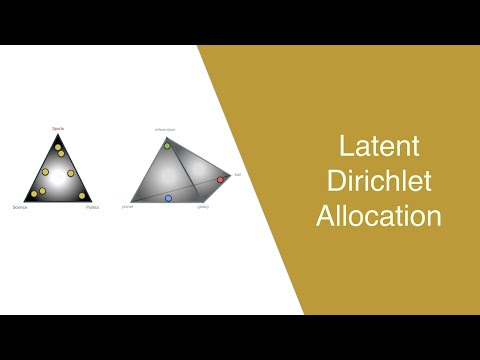

In [3]:
from IPython.display import YouTubeVideo
YouTubeVideo('T05t-SqKArY')

LDA is arguably the most famous topic modelling algorithm out there. Out here we create a simple topic model with 8 topics, but feel free to change it to any other number.

In [45]:
Ktopics = 8
ldamodel = LdaModel(corpus=corpus, num_topics=Ktopics, id2word=dictionary)

**Each topic is a probability distribution over words in the vocabulary.**

In [46]:
ldamodel.show_topics()

[(0,
  '0.008*"people" + 0.007*"government" + 0.005*"shall" + 0.005*"great" + 0.004*"country" + 0.004*"peace" + 0.004*"nation" + 0.004*"world" + 0.003*"free" + 0.003*"new"'),
 (1,
  '0.010*"people" + 0.007*"government" + 0.005*"nation" + 0.005*"great" + 0.005*"peace" + 0.004*"shall" + 0.004*"new" + 0.004*"world" + 0.004*"country" + 0.004*"freedom"'),
 (2,
  '0.008*"people" + 0.007*"government" + 0.006*"nation" + 0.006*"world" + 0.005*"great" + 0.005*"shall" + 0.004*"country" + 0.004*"power" + 0.003*"america" + 0.003*"time"'),
 (3,
  '0.008*"government" + 0.007*"people" + 0.006*"great" + 0.005*"power" + 0.005*"nation" + 0.005*"country" + 0.005*"shall" + 0.005*"world" + 0.004*"new" + 0.003*"constitution"'),
 (4,
  '0.008*"government" + 0.007*"people" + 0.005*"nation" + 0.005*"shall" + 0.004*"country" + 0.004*"great" + 0.004*"power" + 0.004*"world" + 0.004*"new" + 0.003*"union"'),
 (5,
  '0.009*"people" + 0.008*"government" + 0.006*"world" + 0.006*"great" + 0.006*"peace" + 0.005*"nation" 

**Each document is a probability distribution over topics in the corpus.**

In [47]:
# docid 58 refers to Biden's speech
docid = 58
doc_bow = corpus[docid]
ldamodel.get_document_topics(doc_bow)

[(6, 0.99912196)]

### HDP

Hierarchical Dirichlet Process (HDP)is an unsupervised topic model which figures out the number of topics on it's own.

In [48]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [49]:
hdpmodel.show_topics()

[(0,
  '0.007*power + 0.007*great + 0.006*people + 0.006*government + 0.005*shall + 0.005*country + 0.005*constitution + 0.005*union + 0.004*states + 0.003*rights + 0.003*nation + 0.003*powers + 0.003*spirit + 0.003*time + 0.003*united_states + 0.003*war + 0.003*congress + 0.003*state + 0.002*public + 0.002*peace'),
 (1,
  '0.010*world + 0.008*people + 0.008*new + 0.008*america + 0.007*let + 0.005*peace + 0.005*time + 0.005*nation + 0.005*government + 0.004*great + 0.004*today + 0.003*nations + 0.003*freedom + 0.003*country + 0.003*century + 0.003*power + 0.003*work + 0.003*know + 0.003*shall + 0.002*american'),
 (2,
  '0.007*government + 0.005*people + 0.005*country + 0.004*shall + 0.004*business + 0.003*great + 0.003*interests + 0.003*law + 0.003*policy + 0.003*public + 0.003*proper + 0.002*secure + 0.002*congress + 0.002*race + 0.002*administration + 0.002*respect + 0.002*south + 0.002*tariff + 0.002*party + 0.002*legislation'),
 (3,
  '0.008*people + 0.007*government + 0.005*nation

## Visualization

### pyLDAvis 

Thanks to pyLDAvis, we can visualize our topic models in a really handy way. All we need to do is enable our notebook and prepare the object.

In [50]:
pyLDAvis.enable_notebook()

In [51]:
pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.003871 -0.006688       1        1  47.953903
3     -0.005244  0.002610       2        1  17.710421
4     -0.006803 -0.004461       3        1  10.541911
5      0.003268 -0.000176       4        1  10.214976
2      0.002100  0.001937       5        1   4.939947
1     -0.000160  0.002570       6        1   3.301873
0      0.000383  0.002147       7        1   3.066886
7      0.002585  0.002060       8        1   2.270084, topic_info=              Term        Freq       Total Category  logprob  loglift
318         people  513.000000  513.000000  Default  30.0000  30.0000
201     government  449.000000  449.000000  Default  29.0000  29.0000
206          great  292.000000  292.000000  Default  28.0000  28.0000
401          shall  273.000000  273.000000  Default  27.0000  27.0000
287         nation  283.000000  283.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
222           hope    2.459766  109.160248   Topic8  -6.2661  -0.0074
95    constitution    2.872463  144.780654   Topic8  -6.1110  -0.1347
266           life    2.315393   98.424509   Topic8  -6.3266   0.0356
388         rights    2.432193  115.230816   Topic8  -6.2774  -0.0728
1384      american    2.438421  126.234291   Topic8  -6.2749  -0.1614

[690 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
5049      1  0.807838    absorbs
4         1  0.454356        act
4         2  0.151452        act
4         3  0.108180        act
4         4  0.151452        act
...     ...       ...        ...
2869      3  0.082878  years_ago
2869      4  0.082878  years_ago
2869      5  0.041439  years_ago
2869      6  0.041439  years_ago
2869      7  0.041439  years_ago

[1672 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 5, 6, 3, 2, 1, 8])

- Saliency: a measure of how much the term tells you about the topic

- Relevance: a weighted average of the probability of the word given the topic and the word given the topic normalized by the probability of the topic

- Size of bubbles: measures the importance of the topics, relative to the data

## Round-up


Okay - so what have we learned so far? 
By using spaCy, we cleaned up our data super fast. And with Gensim, we built topic models with ease!

# Assignment

- Check out [this website](https://mimno.infosci.cornell.edu/jsLDA/) to do topic modelling without code.
- Train an LDA model on the corpus of movie reviews and display it with `pyLDAvis`. Use [this template](https://colab.research.google.com/github/howard-haowen/NLP-demos/blob/main/gensim_playground.ipynb) to complete the task. What follows is how you could download the corpus.

In [94]:
nltk.download('movie_reviews')
from nltk.corpus import movie_reviews

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [95]:
file_ids = movie_reviews.fileids()
len(file_ids)

2000

In [96]:
movie_reviews.raw(file_ids[0])

'plot : two teen couples go to a church party , drink and then drive . \nthey get into an accident . \none of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . \nwhat\'s the deal ? \nwatch the movie and " sorta " find out . . . \ncritique : a mind-fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . \nwhich is what makes this review an even harder one to write , since i generally applaud films which attempt to break the mold , mess with your head and such ( lost highway & memento ) , but there are good and bad ways of making all types of films , and these folks just didn\'t snag this one correctly . \nthey seem to have taken this pretty neat concept , but executed it terribly . \nso what are the problems with the movie ? \nwell , its main problem is that it\'s simply too jumbled . \nit starts off " normal " but then downshifts into this " fantasy " world in which you , as an audience membe

In [99]:
def moviews2df(file_ids):
    sentiments = ['pos' if id[:3] == 'pos' else 'neg' for id in file_ids]
    texts = [movie_reviews.raw(id) for id in file_ids]
    df = pd.DataFrame(
        {
            "sentiment": sentiments,
            "text": texts,
        }
    )
    return df

In [100]:
moviews_df = moviews2df(file_ids)
moviews_df

,sentiment,text
0,neg,"plot : two teen couples go to a church party ,..."
1,neg,the happy bastard's quick movie review \ndamn ...
2,neg,it is movies like these that make a jaded movi...
3,neg,""" quest for camelot "" is warner bros . ' firs..."
4,neg,synopsis : a mentally unstable man undergoing ...
...,...,...
1995,pos,wow ! what a movie . \nit's everything a movie...
1996,pos,"richard gere can be a commanding actor , but h..."
1997,pos,"glory--starring matthew broderick , denzel was..."
1998,pos,steven spielberg's second epic film on world w...
